# Using Spectra to Study Symmetry and Geometry

## Introduction

Understanding geometry and symmetry is crucial to research in many domains. This is especially true in computational materials science, as a material's properties are determined by the atomic-level structure and organization of its constituents. We would like a discriptor should be invariant to translation, rotation, and permutation of atoms of the same species, as these operations do not change physical properties. Ideally, one could also decode the original geometry (up to a global rotation) form such a descriptor without significant computation. It would also be nice to have a fixed-length vector descriptor that could be easily fed to a neural network.

Considering spherical harmonics are a natural starting point for coming up with such a descriptor. Spherical harmonics are very nice set of basis functions for signals on the sphere and are well suited for describing local atomic environments. This is because atoms don't like to be too close to each other, so they will naturally spread across a sphere. Consequently, higher degrees of spherical harmonics are not needed in order to capture a local environment due to the angular spacing of atoms. Considering this, spectra, which are quantites that can be computed from spherical harmonic coefficients, seem like a natural choice to characterize geometry.

The goal of this project is to better understand the effectiveness and limitations of using spectra as a characterization of geometry and symmetry.

Note: A significant amount of time was spent converting everything from `e3nn-torch` to `e3nn-jax` in order to be able to the trispectrum as well as the power spectrum and bispectrum for higher $l_{max}$, and there are definitely some things that still don't look quite right. In particular, some of the common molecular geometries fail when trying to expand into spherical harmonics for some reason, and inverting the power spectrum + bispectrum gives unusually poor results at times. So while there are issues that need to be resolved, the code is well-documented and set up to rerun quickly.

## Related Work

### Cite and describe 2-5 (or more) papers that you build upon in your project or otherwise inform your project direction.

Related works in this area discuss various choices of descriptors which can be used to characterize local atomic environments, both theoretically and empirically. 

Many traditional local atomic environment descriptors used in cheminformatics are relatively low dimensional descriptors and lose much geometric information. One commonly used descriptor that aims to retain all geometric information when representing a local environment is the smooth overlap of atomic positions (SOAP) descriptor which encodes neighbors a given atom using 3D atom-centered Gaussian functions expanded in a basis of spherical harmonics and radial basis functions. This is very similar to spectra, which uses Dirac delta functions istead of Gaussians and does not include radial basis functions.[1][2][3]

It has also been established that second-order invariants such as the bispectrum are complete. There is also a constructive algorithm that has been proposed for recovering functions from their bispectral values on SO(3).[4]

In practice, it has been shown that atomic positions encoded using the bispectrum can be decoded (up to a global rotation) with a success rate of 97%.[5] However, that study uses a different process of inverting the bispectrum than the method that will be used in this project.




[1] S. De, A. P. Bartók, G. Csányi, and M. Ceriotti, “Comparing molecules and solids across structural and alchemical space,” Phys. Chem. Chem. Phys., vol. 18, no. 20, pp. 13754–13769, 2016, doi: 10.1039/C6CP00415F.

[2] B. Cheng et al., “Mapping Materials and Molecules,” Acc. Chem. Res., vol. 53, no. 9, pp. 1981–1991, Sep. 2020, doi: 10.1021/acs.accounts.0c00403.

[3] A. P. Bartók, R. Kondor, and G. Csányi, “On representing chemical environments,” Phys. Rev. B, vol. 87, no. 18, p. 184115, May 2013, doi: 10.1103/PhysRevB.87.184115.

[4] R. Kakarala, “The bispectrum as a source of phase-sensitive invariants for Fourier descriptors: a group-theoretic approach.” arXiv, Feb. 13, 2012. Accessed: May 15, 2023. [Online]. Available: http://arxiv.org/abs/0902.0196

[5] M. Uhrin, “Through the eyes of a descriptor: Constructing complete, invertible descriptions of atomic environments,” Phys. Rev. B, vol. 104, no. 14, p. 144110, Oct. 2021, doi: 10.1103/PhysRevB.104.144110.

## Background

Given a set of points centered about a central point, the local environment can be expressed as a sum of radial Dirac delta functions:

$$\begin{aligned}\large
\sum_{i=1}^{N} v_i \delta(\vec r_i)
\end{aligned}$$

From this function, a spherical harmonic signal $x$ is obtained by expanding this function into its spherical harmonic coefficients:

$$\begin{aligned}\large
x = c_l^m = \int \left(\sum_{i=1}^{N} v_i \delta(\vec{r_i} - \vec{x})\right) Y_{l,m}(\vec{x}) d\vec{x} = \sum_{i=1}^{N} v_i Y_{l,m}(\vec{r_i})
\end{aligned}$$

Taking this spherical harmonic signal $x$, one can calculate the spectra of order $d$ by computing repeated symmetric tensor tensor products ($x^{\otimes (d+1)}$) and extracting the scalar and pseudoscalar coefficients. The first, second, and third order spectra are more commonly known as the power spectrum, bispectrum, and trispectrum, respectively.

$$\begin{aligned}\large
x^{\otimes (d+1)} \longrightarrow (0, e) \oplus (0, o)
\end{aligned}$$

Spectra are useful quantities to consider due to being invariants. That is, rotating the initial function then computing its spectra will result in the same spectra.

## Methods 

`e3nn-jax` will be used to compute and represent spherical harmonic expansions and compute power spectra, bispectra, and trispectra for up to lmax = 8, 6, 4, respectively. No models will be trained as part of this project.

## Experiments 

There are many different studies that can be done to better understand how spectra characterizes geometry and symmetry. Different geometries (such as those in 2D vs 3D, as well as common molecular geometries) can be generated and distorted to see how the spectra change. It is also  informative to add noise to these geometries and study how robust the spectra is by performing dimensionality reduction and seeing how the original geometries are organized and clustered. Additionally, the maximum value of l considered and order of the spectra can be varied to see how the results change. The invertibility of the spectra can also be studied using different combinations of spectra and $l_{max}$ to see how robust it is.

### Imports

In [1]:
from typing import Optional, Union, Callable, Tuple  # Type hints
import e3nn_jax as e3nn  # E(3)-equivariant neural networks
import jax  # Accelerated numerical computing and automatic differentiation
import optax  # Gradient-based optimization
import jax.numpy as jnp  # Compatibility with JAX functions
import chex  # JAX-specific testing utilities
import matplotlib.pyplot as plt  # Data visualization
from matplotlib.lines import Line2D  # Custom line styles
import plotly  # Interactive data visualization
import plotly.graph_objects as go  # Interactive plots
import pandas as pd  # Data manipulation and analysis
from tqdm import tqdm  # Progress bars and iteration monitoring
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.manifold import TSNE  # Dimensionality reduction

### Some helpful functions

We begin by defining the crucial functions required to compute the different spectra.

In [2]:
def powerspectrum(x: e3nn.IrrepsArray) -> e3nn.IrrepsArray:
    """
    Computes the power spectrum given an array of irreps.

    Parameters:
        x (e3nn.IrrepsArray): Input array of irreducible representations.

    Returns:
        e3nn.IrrepsArray: The power spectrum of the input array.
    """
    rtp = e3nn.reduced_symmetric_tensor_product_basis(x.irreps, 2, keep_ir=['0o', '0e'])
    return e3nn.IrrepsArray(rtp.irreps, jnp.einsum("i,j,ijz->z", x.array, x.array, rtp.array)).array

def bispectrum(x: e3nn.IrrepsArray) -> e3nn.IrrepsArray:
    """
    Computes the bispectrum given an array of irreps.

    Parameters:
        x (e3nn.IrrepsArray): Input array of irreps.

    Returns:
        e3nn.IrrepsArray: The bispectrum of the input array.
    """
    rtp = e3nn.reduced_symmetric_tensor_product_basis(x.irreps, 3, keep_ir=['0o', '0e'])
    return e3nn.IrrepsArray(rtp.irreps, jnp.einsum("i,j,k,ijkz->z", x.array, x.array, x.array, rtp.array)).array

def trispectrum(x: e3nn.IrrepsArray) -> e3nn.IrrepsArray:
    """
    Computes the trispectrum given an array of irreps.

    Parameters:
        x (e3nn.IrrepsArray): Input array of irreps.

    Returns:
        e3nn.IrrepsArray: The trispectrum of the input array.
    """
    rtp = e3nn.reduced_symmetric_tensor_product_basis(x.irreps, 4, keep_ir=['0o', '0e'])
    return e3nn.IrrepsArray(rtp.irreps, jnp.einsum("i,j,k,l,ijklz->z", x.array, x.array, x.array, x.array, rtp.array)).array

The following two functions aid in studying a diverse range of geometries: `generate_random_geometries` generates an array of random geometries which can be chosen to be constrained to 2D, while `generate_noisy_geometries` takes an existing geometry and returns an array of distorted geometries.

In [3]:
def generate_random_geometries(num_geometries: int = 1000, min_points: int = 1, max_points: int = 8, constrained_to_2d: bool = False) -> jnp.ndarray:
    """
    Generates an array of random geometries, either 3D or constrained to 2D (i.e., z-coordinate is 0).

    Parameters:
    num_geometries: int, optional
        The number of separate geometries to generate. Default is 1000.
    min_points: int, optional
        The minimum number of points to generate in each geometry. Default is 1.
    max_points: int, optional
        The maximum number of points to generate in each geometry. Default is 12.
    constrained_to_2d: bool, optional
        Whether the points should be constrained to the xy-plane. Default is False.
    
    Returns:
    jnp.ndarray: An array of geometries. The first dimension corresponds to different geometries.
    """
    all_geometries = []
    max_points_in_a_geometry = 0

    # Initialize the random number generator once
    rng = jax.random.PRNGKey(1)
    
    for _ in range(num_geometries):
        # Split the RNG for this iteration
        rng, iteration_rng = jax.random.split(rng)

        # Determine the number of points to generate for this geometry
        num_points = jax.random.randint(iteration_rng, (), min_points, max_points+1)
        max_points_in_a_geometry = max(max_points_in_a_geometry, num_points)

        # Split the RNG
        direction_rng, iteration_rng = jax.random.split(iteration_rng)

        # Generate the directions for the points
        if constrained_to_2d:
            directions = jax.random.normal(direction_rng, (num_points, 2))
            directions = jnp.pad(directions, ((0, 0), (0, 1)))  # Pad with zeros for 3D representation
        else:
            directions = jax.random.normal(direction_rng, (num_points, 3))
            
        # Normalize the directions
        directions /= jnp.linalg.norm(directions, axis=-1, keepdims=True)

        # Split the RNG for scaling
        scaling_rng, _ = jax.random.split(direction_rng)

        # Scale the directions to generate the points for this geometry
        geometry_points = directions * (jax.random.normal(scaling_rng, (num_points, 1)) * 0.5 + 1.0)
        
        all_geometries.append(geometry_points)

    # Pad the geometries with zeros to make them all the same shape
    for i, geometry in enumerate(all_geometries):
        if geometry.shape[0] < max_points_in_a_geometry:
            all_geometries[i] = jnp.pad(geometry, ((0, max_points_in_a_geometry - geometry.shape[0]), (0, 0)))

    return jnp.stack(all_geometries)


In [4]:
def generate_noisy_geometries(geometry: jnp.ndarray, num_geometries: int = 1, noise_level: float = 0.1) -> jnp.ndarray:
    """
    Generates noisy versions of a given 3D geometry.

    Parameters:
        geometry: jnp.ndarray
            The original 3D geometry.
        num_geometries: int, optional
            The number of noisy geometries to generate. Default is 1.
        noise_level: float, optional
            The scale of the noise to add to the geometry. Default is 0.1.

    Returns:
        jnp.ndarray: An array of noisy geometries. The first dimension corresponds to different geometries.
    """
    coordination_number, _ = geometry.shape
    rng = jax.random.PRNGKey(0)
    all_geometries = []

    for _ in range(num_geometries):
        rng, iteration_rng = jax.random.split(rng)
        noise = jax.random.uniform(iteration_rng, (coordination_number, 3)) * noise_level
        noisy_geometry = geometry + noise
        all_geometries.append(noisy_geometry)

    # Ensure all geometries have 8 rows
    max_rows = 8
    for i, geometry in enumerate(all_geometries):
        if geometry.shape[0] < max_rows:
            all_geometries[i] = jnp.pad(geometry, ((0, max_rows - geometry.shape[0]), (0, 0)))

    return jnp.stack(all_geometries)



`geometries_dict_to_df` is a helper function that is used to store geometries in a pandas DataFrame

In [5]:
def geometries_dict_to_df(geometries_dict):
    """
    Convert a dictionary of geometries into a Pandas DataFrame.

    Parameters:
        geometries_dict (dict): A dictionary where keys are categories and values are 
                                lists of geometries associated with that category.

    Returns:
        pd.DataFrame: A pandas DataFrame with two columns: "category" and "geometry". 
                   Each row represents a category-geometry pair.
    """
    data = [(category, geometry) for category, geometries in geometries_dict.items() for geometry in geometries]
    return pd.DataFrame(data, columns=["category", "geometry"])

Next, we the function used to expand a signal on a sphere (represented as a sum of Dirac delta functions) into its spherical harmonic coefficients. This is effectively the same function as `e3nn.io.SphericalTensor.with_peaks_at` in `e3nn-torch`. 

Note: I plan to make a pull request after this project to implement this (properly) in `e3nn-jax`

In [6]:
def compute_sh_expansion(vectors, lmax):
    """
    Compute a spherical harmonics expansion given Dirac delta functions defined on the sphere.

    Parameters:
        vec (jnp.ndarray): An array of vectors. Each row represents a vector.
        lmax (int): The maximum degree of the spherical harmonics expansion.

    Returns:
        e3nn.IrrepsArray: An array representing the weighted sum of the spherical harmonics expansion.
    """
    values = jnp.linalg.norm(vectors, axis=1)

    vectors = vectors[values != 0] # will these two lines work?
    values = values[values != 0]
 
    coeff_list = [e3nn.spherical_harmonics(i, e3nn.IrrepsArray("1o", vectors), normalize=True).array for i in range(lmax + 1)]
    coeff = jnp.concatenate(coeff_list, axis=1)
    
    A = jnp.einsum(
        "ai,bi->ab",
        coeff,
        coeff
    )
    solution = jnp.array(jnp.linalg.lstsq(A, values)[0]) #.reshape(-1)    
    # assert jnp.max(jnp.abs(values - A @ solution)) < 1e-5 * jnp.max(jnp.abs(values))
    if jnp.max(jnp.abs(values - A @ solution)) >= 1e-5 * jnp.max(jnp.abs(values)):
        return None

    sh_expansion = solution @ coeff
    
    irreps = {
        0: "1x0e",
        1: "1x0e + 1x1o",
        2: "1x0e + 1x1o + 1x2e",
        3: "1x0e + 1x1o + 1x2e + 1x3o",
        4: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e",
        5: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o",
        6: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e",
        7: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o",
        8: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o + 1x8e",
        9: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o + 1x8e + 1x9o",
        10: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o + 1x8e + 1x9o + 1x10e",
        11: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o + 1x8e + 1x9o + 1x10e + 1x11o",
        12: "1x0e + 1x1o + 1x2e + 1x3o + 1x4e + 1x5o + 1x6e + 1x7o + 1x8e + 1x9o + 1x10e + 1x11o + 1x12e"
    }    
    
    return e3nn.IrrepsArray(irreps[lmax], sh_expansion)
    
    


# def compute_sh_expansion(vec, lmax):
#     """
#     Compute a spherical harmonics expansion given Dirac delta functions defined on the sphere.

#     Parameters:
#         vec (jnp.ndarray): An array of vectors. Each row represents a vector.
#         lmax (int): The maximum degree of the spherical harmonics expansion.

#     Returns:
#         e3nn.IrrepsArray: An array representing the weighted sum of the spherical harmonics expansion.
#     """
#     weights = jnp.linalg.norm(vec, axis=1)
#     return e3nn.sum(e3nn.s2_dirac(vec, lmax, p_val=1, p_arg=-1) * weights[:, None], axis=0)

`compute_spectra` uses `compute_sh_expansion` and the spectrum functions (`powerspectrum`, `bispectrum`, and `trispectrum`) to compute the spectra and store the values in additional columns of the DataFrame

In [17]:
def compute_spectra(df, max_lmaxes=[8, 6, 4]):
    """
    Compute and append various spectra (power, bi, tri) to the input dataframe for different maximum degrees of spherical harmonics (lmax).

    Parameters:
        df: pd.DataFrame
            Input DataFrame. Expected to have a 'geometry' column with the geometries for which the spectra will be computed.
        max_lmaxes: list of int, optional
            List of maximum degrees of spherical harmonics for which to compute each spectra. Defaults to [8, 6, 4].
            
    Returns:
        df: The input DataFrame with additional columns containing the computed spectra.
    """

    # Functions to compute different types of spectra
    spectrum_functions = [powerspectrum, bispectrum, trispectrum]

    # Names corresponding to the spectrum functions
    function_names = ["powerspectrum", "bispectrum", "trispectrum"]

    # Compute and append each spectrum for each maximum degree of spherical harmonic
    for max_lmax, spectrum_function, function_name in zip(max_lmaxes, spectrum_functions, function_names):
        for lmax in range(1, max_lmax + 1):
            print(f"Computing {function_name} for lmax = {lmax}")
            # Compute spherical harmonic expansion for each geometry
            geometries = jnp.array(df.geometry.tolist())
            sphs = []
            
            to_delete = []
            for i, geometry in enumerate(geometries):
                sph = compute_sh_expansion(geometry, lmax=lmax)
                if sph:
                    sphs.append(sph)
                else:
                    to_delete.append(i)
            df = df.drop(to_delete).reset_index(drop=True)
                        
#             sh_expansion_failed = False
#             for geometry in geometries:
#                 sph = compute_sh_expansion(geometry, lmax=lmax)
#                 if sph is None:
#                     sh_expansion_failed = True
#                     break
#                 else:
#                     sphs.append(sph)
            
#             if sh_expansion_failed:
#                 continue
            
            # sphs = jax.vmap(lambda vectors: compute_sh_expansion(vectors=vectors, lmax=lmax))(geometries)

            # Compute spectrum for each spherical harmonic expansion
            spectra = map(spectrum_function, sphs)
            # spectra = jax.vmap(spectrum_function)(sphs)

            # Append spectrum to DataFrame
            df[f"{function_name}{lmax}"] = list(spectra)
            
    return df

`calculate_spectra_dim_reduction` performs dimensionality reduction on the spectra, using both PCA and t-SNE.

In [19]:
def calculate_spectra_dim_reduction(df):
    """
    Perform dimensionality reduction (PCA and t-SNE) on spectra columns and 
    appends first two components of both methods as new columns.

    Parameters:
        df: pandas.DataFrame
            Input DataFrame. Expected to have columns with 'spectrum' in their names.
    """

    # Get list of spectra columns
    spectra_columns = [col for col in df.columns if 'spectrum' in col]
    
    for col in spectra_columns:
        print(f"Computing dim reduction for {col}")
        # Create an array of arrays for the spectra
        spectra = jnp.array(df[col].tolist())

        # PCA dimensionality reduction
        pca = PCA(n_components=2)
        spectra_pca = pca.fit_transform(spectra)
        df[f"{col}_pca1"] = spectra_pca[:, 0]
        df[f"{col}_pca2"] = spectra_pca[:, 1]
        
        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2)
        spectra_tsne = tsne.fit_transform(spectra)
        df[f"{col}_tsne1"] = spectra_tsne[:, 0]
        df[f"{col}_tsne2"] = spectra_tsne[:, 1]

# def calculate_spectra_dim_reduction(df):

#     spectra_columns = [col for col in df.columns if 'spectrum' in col]
    
#     for col in spectra_columns:
    
#         spectra = jnp.array([jnp.array(s) for s in df[col]])

#         pca = PCA(n_components=2)
#         spectra_pca = pca.fit_transform(spectra)
#         df[f"{col}_pca1"] = spectra_pca[:, 0]
#         df[f"{col}_pca2"] = spectra_pca[:, 1]
        
#         tsne = TSNE(n_components=2)
#         spectra_tsne = tsne.fit_transform(spectra)
#         df[f"{col}_tsne1"] = spectra_tsne[:, 0]
#         df[f"{col}_tsne2"] = spectra_tsne[:, 1]

`plot_spectra_dim_reduction` can then be used to visualized the first two components of the dimensionality reduction

In [9]:
def plot_spectra_dim_reduction(df, spectrum_name, method):
    """
    Creates subplots to visualize spectra after performing dimensionality reduction.

    Parameters:
        df: pandas.DataFrame
            Input DataFrame. Expected to have columns corresponding dimensionality reduction
            of the spectra, with names of the format {spectrum_name}{lmax}_{method}{1 or 2}.
        spectrum_name: str
            The spectra to be visualized (either "powerspectrum, bispectrum, or trispectrum")
        method: str
            The dimensionality reduction to be visualized (either "pca" or "tsne")
    """
    colors = [
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # olive
        "#17becf",  # cyan
        "#e7298a",  # dark pink
        "#66a61e",  # dark green
    ]

    cols = [col.split('_')[0] for col in df.columns if spectrum_name in col.split('_')[0]]
    num_plots = max(int(col[-1]) for col in cols)
    cats = list(set(df["category"]))

    # Create the subplots
    fig, axes = plt.subplots(2, num_plots // 2, figsize=(5 * (num_plots // 2 + 1), 10))

    # for storing legend information
    lines = [Line2D([0], [0], color=color, marker='o', markersize=10, linestyle='') for color in colors[:len(cats)]]

    for i in range(num_plots):
        row = i // (num_plots // 2)
        col = i % (num_plots // 2)

        lmax = i + 1

        ax = axes[row, col]

        if f"{spectrum_name}{lmax}_{method}1" in df.columns:
        
            for i, cat in enumerate(cats):
                ax.scatter(df[df["category"] == cat][f"{spectrum_name}{lmax}_{method}1"],
                           df[df["category"] == cat][f"{spectrum_name}{lmax}_{method}2"],
                           color=colors[i], s=1, alpha=0.8)

            ax.set_title(f'{ {"pca": "PCA", "tsne": "t-SNE"}[method] } of the { {"powerspectrum": "Power Spectrum", "bispectrum": "Bispectrum", "trispectrum": "Trispectrum"}[spectrum_name] } (lmax={lmax})')

        if row == 1:  # The bottom row
            ax.set_xlabel(f'1st Component of { {"pca": "PCA", "tsne": "t-SNE"}[method] }')
        if col == 0:  # The leftmost column
            ax.set_ylabel(f'2nd Component of { {"pca": "PCA", "tsne": "t-SNE"}[method] }')

    # Add legend on the right of the subplots
    fig.legend(lines, cats, loc='center right', bbox_to_anchor=(1.125, 0.5))

    plt.tight_layout()
    plt.show()

## Study 1: 2D vs 3D

To begin, we consider how well different spectra and $l_{max}$ can distinguish between 3D points centered about a point compared to 3D points that are constrained to 2D. 10000 geometries  are generated for both categories, with between 1 and 8 neighbors included in each geometry. Different radii are also randomly generated for each of the points in order to study a more diverse set of geometries. Then the power spectrum, bispectrum, and trispectrum are computed for $l_{max} = 8, 6, 4$, respectively before computing dimensionality reduction and visualizing. 

In [24]:
num_geometries = 10000
geometries_dict = {"2D-Constrained": generate_random_geometries(num_geometries=num_geometries, max_points=8, constrained_to_2d=True), "3D": generate_random_geometries(num_geometries=num_geometries, max_points=8, constrained_to_2d=False)}
dimensional_geometries_df = geometries_dict_to_df(geometries_dict)
dimensional_geometries_df = compute_spectra(dimensional_geometries_df, [8, 6, 4])
calculate_spectra_dim_reduction(dimensional_geometries_df)

Computing powerspectrum for lmax = 1
Computing powerspectrum for lmax = 2
Computing powerspectrum for lmax = 3
Computing powerspectrum for lmax = 4
Computing powerspectrum for lmax = 5
Computing powerspectrum for lmax = 6
Computing powerspectrum for lmax = 7
Computing powerspectrum for lmax = 8
Computing bispectrum for lmax = 1
Computing bispectrum for lmax = 2
Computing bispectrum for lmax = 3
Computing bispectrum for lmax = 4
Computing bispectrum for lmax = 5
Computing bispectrum for lmax = 6
Computing trispectrum for lmax = 1
Computing trispectrum for lmax = 2
Computing trispectrum for lmax = 3
Computing trispectrum for lmax = 4
Computing dim reduction for powerspectrum1
Computing dim reduction for powerspectrum2
Computing dim reduction for powerspectrum3
Computing dim reduction for powerspectrum4
Computing dim reduction for powerspectrum5
Computing dim reduction for powerspectrum6
Computing dim reduction for powerspectrum7
Computing dim reduction for powerspectrum8
Computing dim re

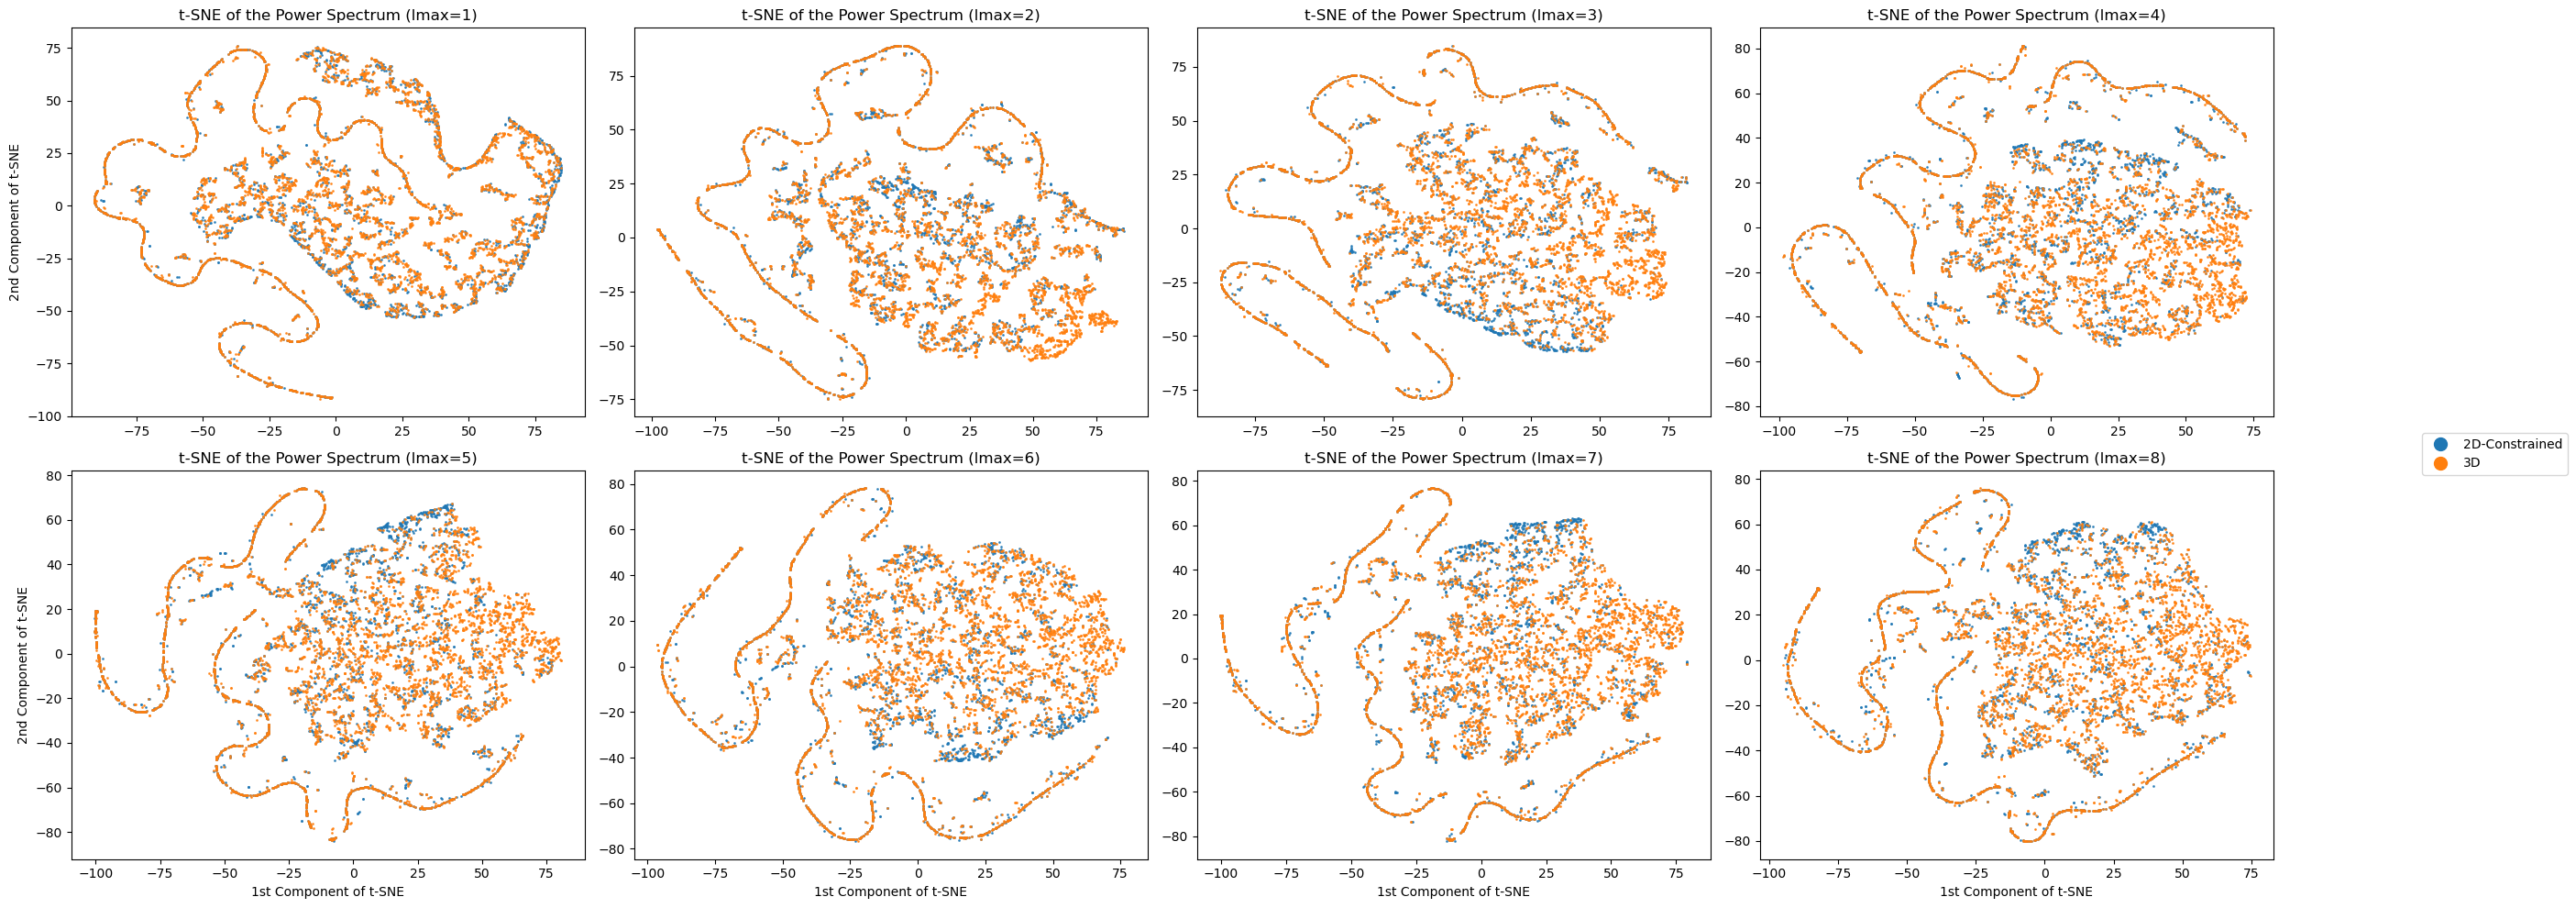

In [25]:
plot_spectra_dim_reduction(dimensional_geometries_df, "powerspectrum", "tsne")

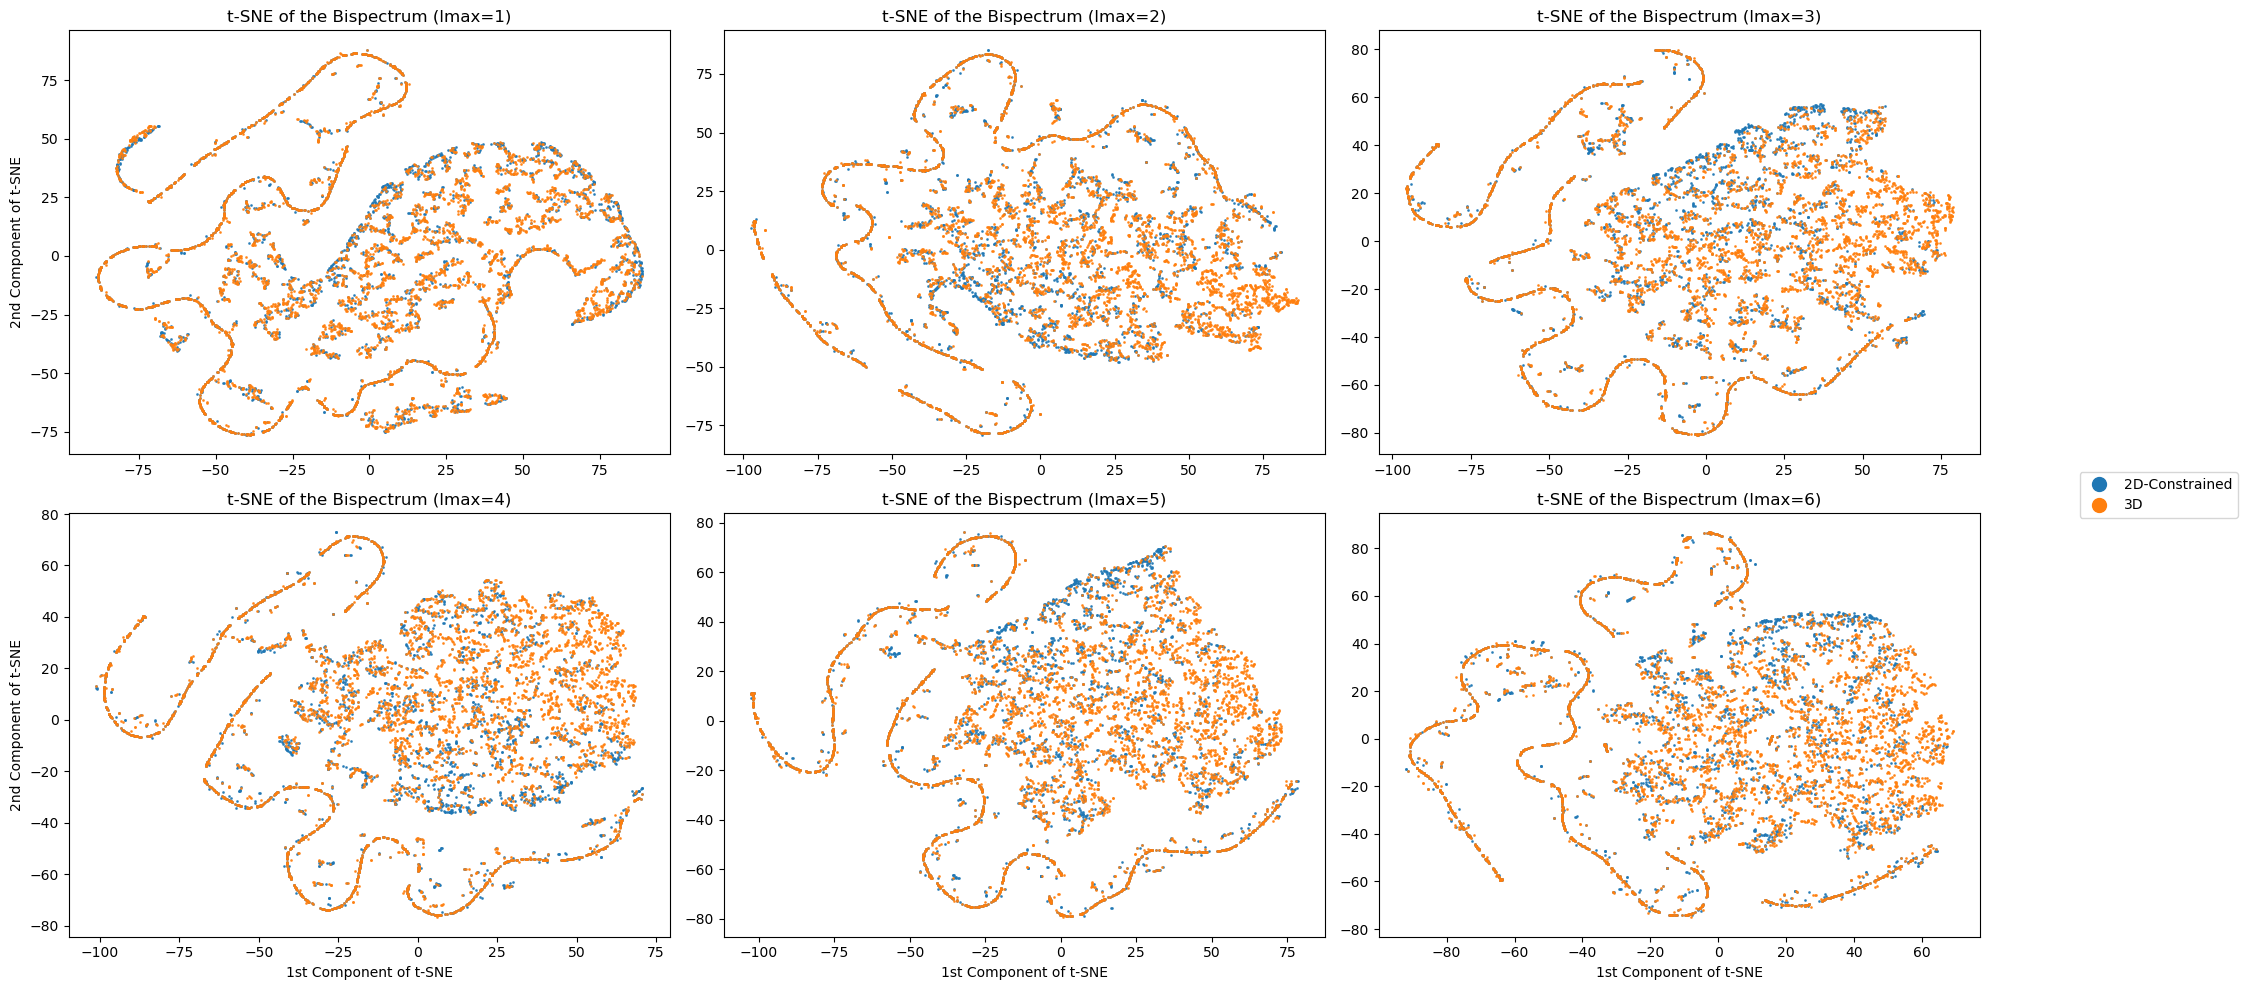

In [26]:
plot_spectra_dim_reduction(dimensional_geometries_df, "bispectrum", "tsne")

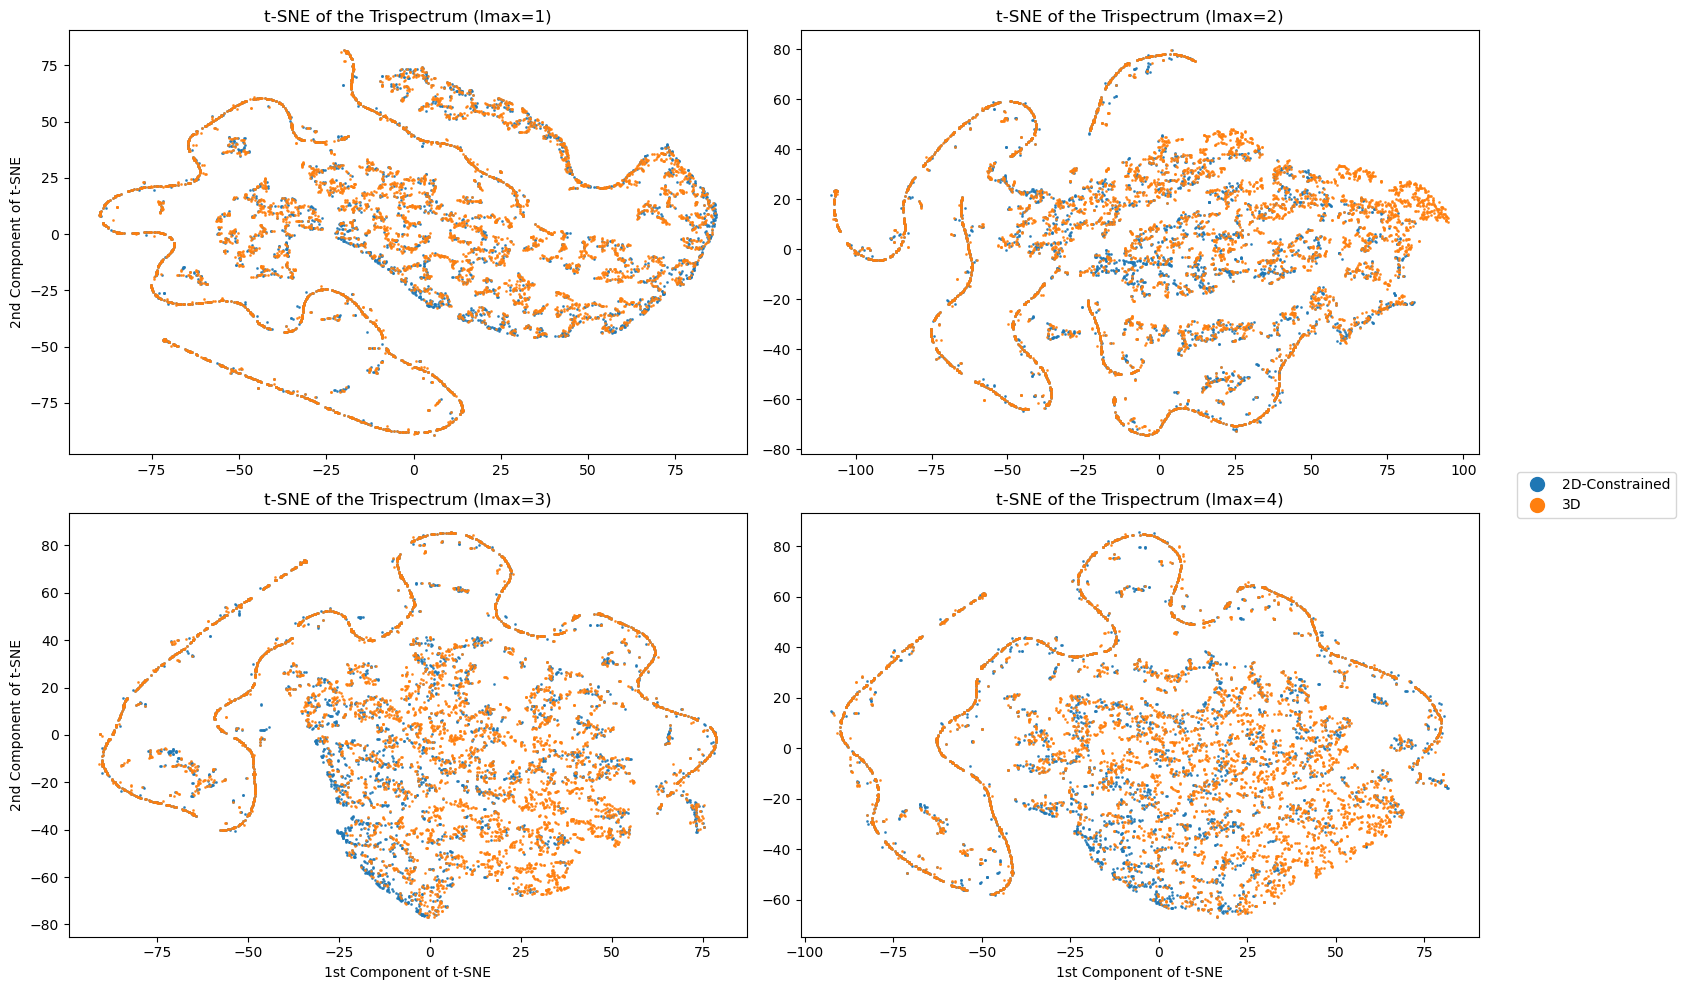

In [27]:
plot_spectra_dim_reduction(dimensional_geometries_df, "trispectrum", "tsne")

These plots show that the different spectra and $l_{max}$ cannot distinguish between 2D and 3D points effectively. This is confirmed below when training a logistic regression classifier on the spectra:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np



def classification_accuracy(df, xname):
    
    # assume X is a list of numpy arrays and y is a list of labels (2 or 3)
    X = np.vstack(df[xname])
    y = np.array(df["category"])

    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # encode labels as numeric values
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # train logistic regression classifier
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)

    # predict labels on test set
    y_pred = clf.predict(X_test)

    # evaluate performance
    accuracy = metrics.accuracy_score(y_test, y_pred)
    # precision = metrics.precision_score(y_test, y_pred, average='macro')
    # recall = metrics.recall_score(y_test, y_pred, average='macro')
    # f1_score = metrics.f1_score(y_test, y_pred, average='macro')
    
    # print("Accuracy: {:.2f}".format(accuracy))
    # print("Precision: {:.2f}".format(precision))
    # print("Recall: {:.2f}".format(recall))
    # print("F1-score: {:.2f}".format(f1_score))
    
    return accuracy




In [32]:

def plot_classification_accuracies(df, title):

    lmaxes = [1, 2, 3, 4, 5, 6, 7, 8]

    poweracc = [classification_accuracy(df, f"powerspectrum{i}") for i in range(1, 9)]
    biacc = [classification_accuracy(df, f"bispectrum{i}") for i in range(1, 7)]
    triacc = [classification_accuracy(df, f"trispectrum{i}") for i in range(1, 5)]

    label1 = 'power spectrum'
    label2 = 'bispectrum'
    label3 = 'trispectrum'

    plt.figure(figsize=(10,6))

    # Plotting
    plt.plot(lmaxes, poweracc, label=label1)
    plt.plot(lmaxes[:6], biacc, label=label2)
    plt.plot(lmaxes[:4], triacc, label=label3)

    # Adding legend, title and labels
    plt.legend()
    plt.title(title)
    plt.xlabel('lmax')
    plt.ylabel('Accuracy')

    # Display the plot
    plt.show()


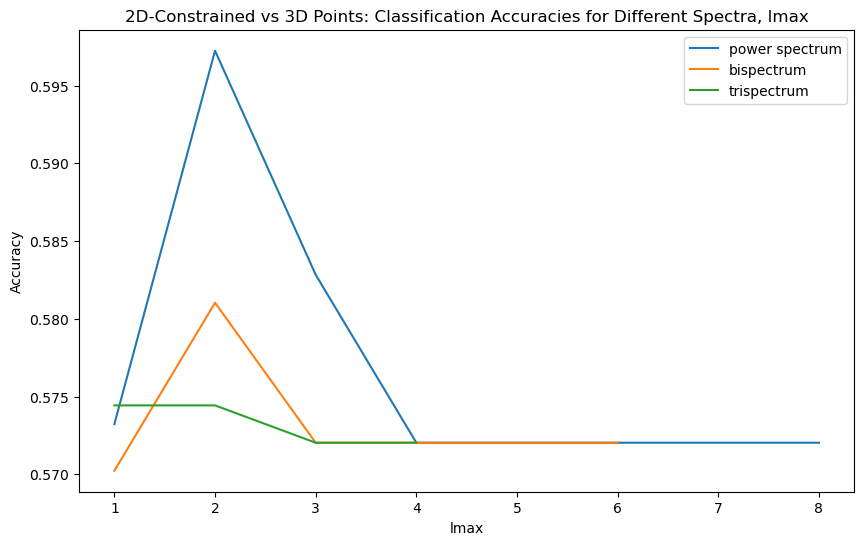

In [33]:
plot_classification_accuracies(dimensional_geometries_df, title='2D-Constrained vs 3D Points: Classification Accuracies for Different Spectra, lmax')

From this, we can see that there is not a significant signature corresponding to 2D vs 3D when computing different spectra.

## Study 2: Common Molecular Geometries

Next, it is informative to consider whether or not spectra can distinguish between different common molecular geometries. This is an important problem in the context of materials science and chemistry, as a local atomic environment descriptor is not very useful if it cannot effectively distinguish between different common geometries that are found in structures. 

In order to study this, 2000 geometries  are generated for each of the following common molecular geometries, with noise being added to each one in order to emulate the fact that real structures are distortions from idealized geometries. Then the power spectrum, bispectrum, and trispectrum are computed for $l_{max} = 8, 6, 4$, respectively before computing dimensionality reduction and visualizing. 

In [36]:
# Linear
linear = jnp.array([
    [1, 0, 0],
    [-1, 0, 0]
])

# Trigonal planar
trigonal_planar = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0]
])

# Bent (assume 120 degrees)
bent = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0]
])

# Tetrahedral
tetrahedral = jnp.array([
    [0, 0, 1],
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Trigonal pyramidal
trigonal_pyramidal = jnp.array([
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Trigonal bipyramidal
trigonal_bipyramidal = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0],
    [0, 0, 1],
    [0, 0, -1]
])

# Seesaw
seesaw = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# T-shaped
t_shaped = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0]
])

# Octahedral
octahedral = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

# Square pyramidal
square_pyramidal = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1]
])

# Square planar
square_planar = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0]
])

# Cube antiprism
cube_antiprism = jnp.array([
    [-0.31245971, -0.75434448, -0.57735027],
    [ 0.75434448, -0.31245971, -0.57735027],
    [ 0.31245971,  0.75434448, -0.57735027],
    [-0.75434448,  0.31245971, -0.57735027],
    [-0.75434448, -0.31245971,  0.57735027],
    [ 0.31245971, -0.75434448,  0.57735027],
    [ 0.75434448,  0.31245971,  0.57735027],
    [-0.31245971,  0.75434448,  0.57735027]
])


In [37]:
molecular_geometries = {
    "linear": linear,
    "trigonal_planar": trigonal_planar,
    "bent": bent,
    "tetrahedral": tetrahedral,
    "trigonal_pyramidal": trigonal_pyramidal,
    "trigonal_bipyramidal": trigonal_bipyramidal,
    "seesaw": seesaw,
    "t_shaped": t_shaped,
    "octahedral": octahedral,
    "square_pyramidal": square_pyramidal,
    "square_planar": square_planar,
    "cube_antiprism": cube_antiprism
}

In [42]:
num_geometries = 2000
geometries_dict = {name: generate_noisy_geometries(geometry=geometry, num_geometries=num_geometries, noise_level = 0.25) for name, geometry in molecular_geometries.items()}
molecular_geometries_df = geometries_dict_to_df(geometries_dict)
molecular_geometries_df = compute_spectra(molecular_geometries_df, [8, 6, 4])
calculate_spectra_dim_reduction(molecular_geometries_df)

Computing powerspectrum for lmax = 1
Computing powerspectrum for lmax = 2
Computing powerspectrum for lmax = 3
Computing powerspectrum for lmax = 4
Computing powerspectrum for lmax = 5
Computing powerspectrum for lmax = 6
Computing powerspectrum for lmax = 7
Computing powerspectrum for lmax = 8
Computing bispectrum for lmax = 1
Computing bispectrum for lmax = 2
Computing bispectrum for lmax = 3
Computing bispectrum for lmax = 4
Computing bispectrum for lmax = 5
Computing bispectrum for lmax = 6
Computing trispectrum for lmax = 1
Computing trispectrum for lmax = 2
Computing trispectrum for lmax = 3
Computing trispectrum for lmax = 4
Computing dim reduction for powerspectrum1
Computing dim reduction for powerspectrum2
Computing dim reduction for powerspectrum3
Computing dim reduction for powerspectrum4
Computing dim reduction for powerspectrum5
Computing dim reduction for powerspectrum6
Computing dim reduction for powerspectrum7
Computing dim reduction for powerspectrum8
Computing dim re

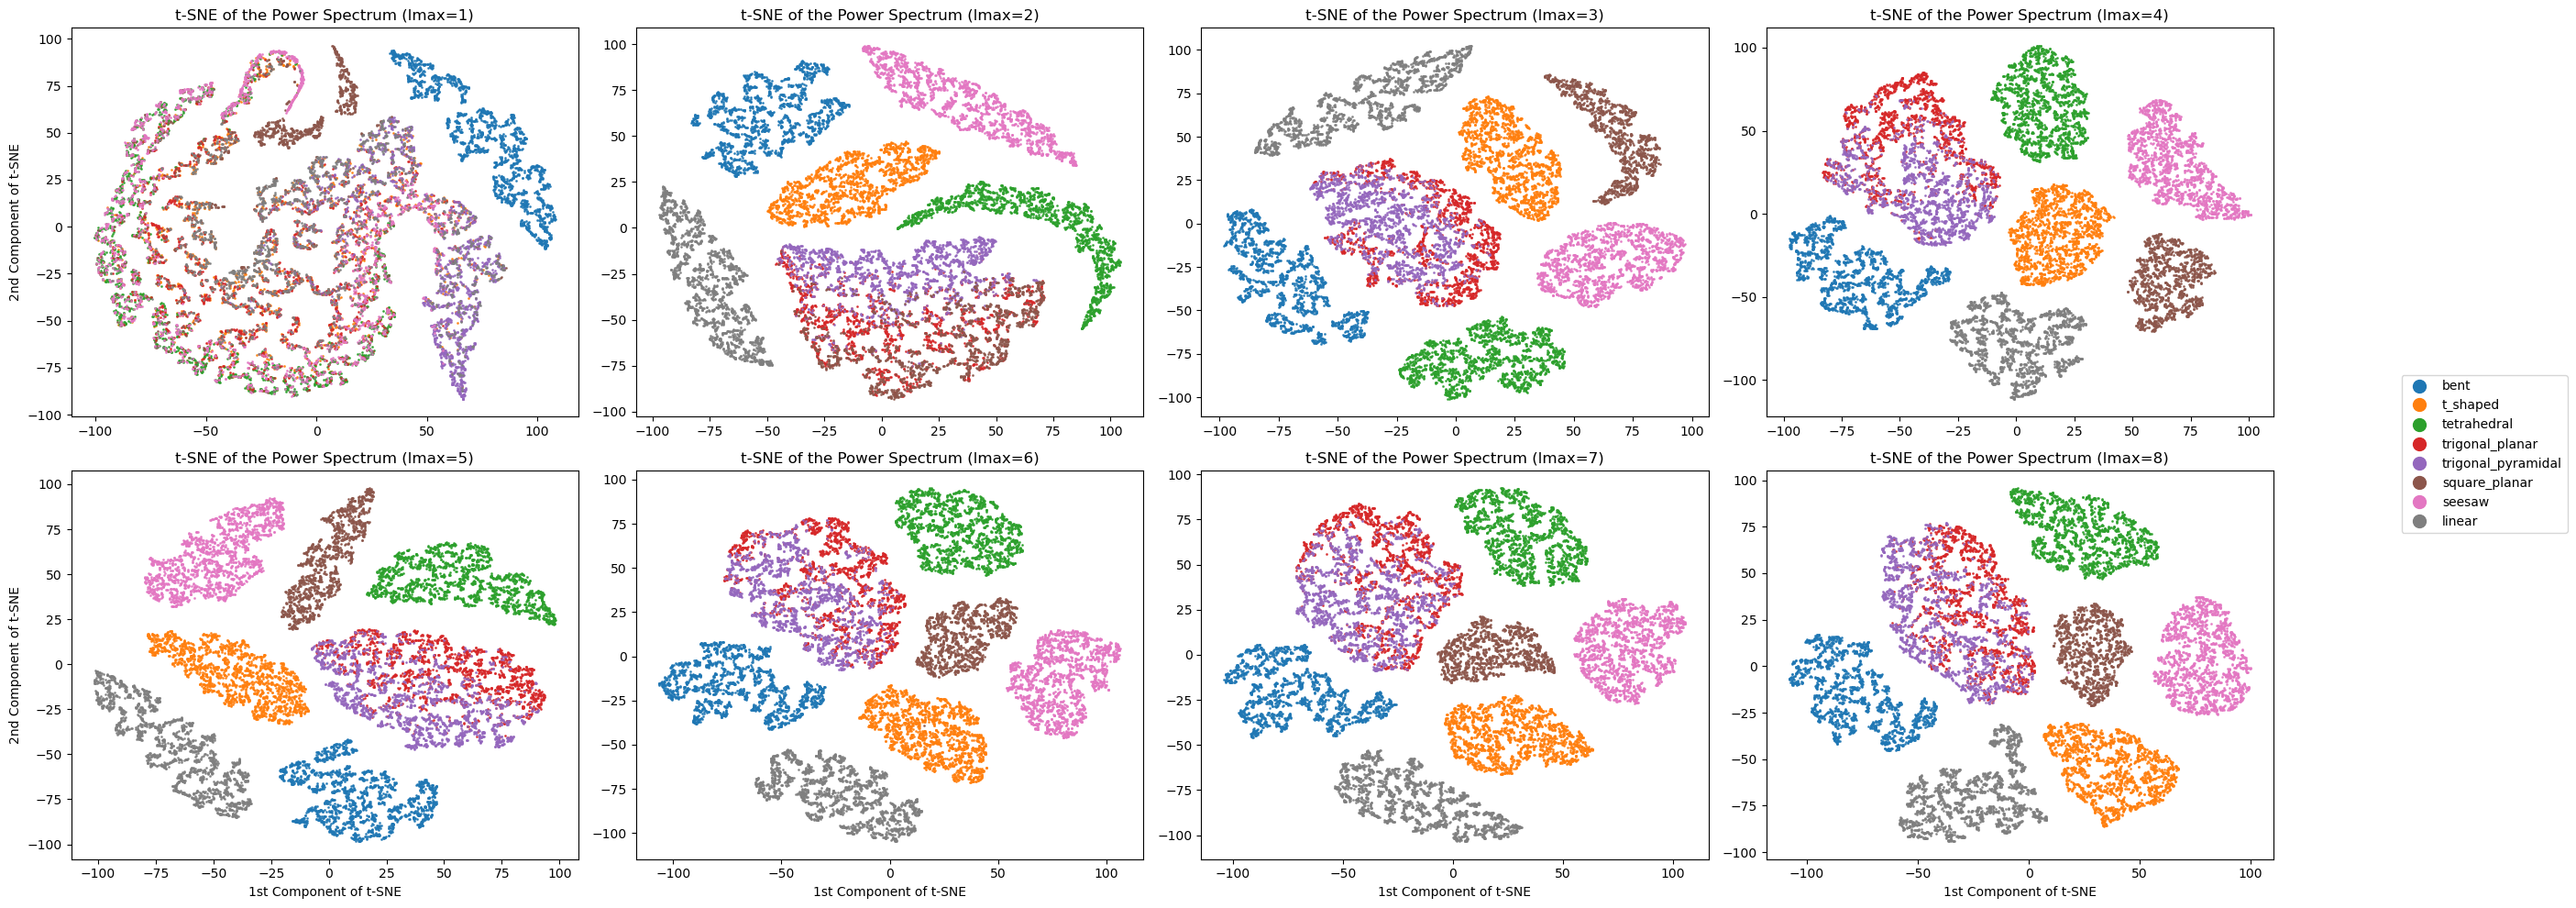

In [43]:
plot_spectra_dim_reduction(molecular_geometries_df, "powerspectrum", "tsne")

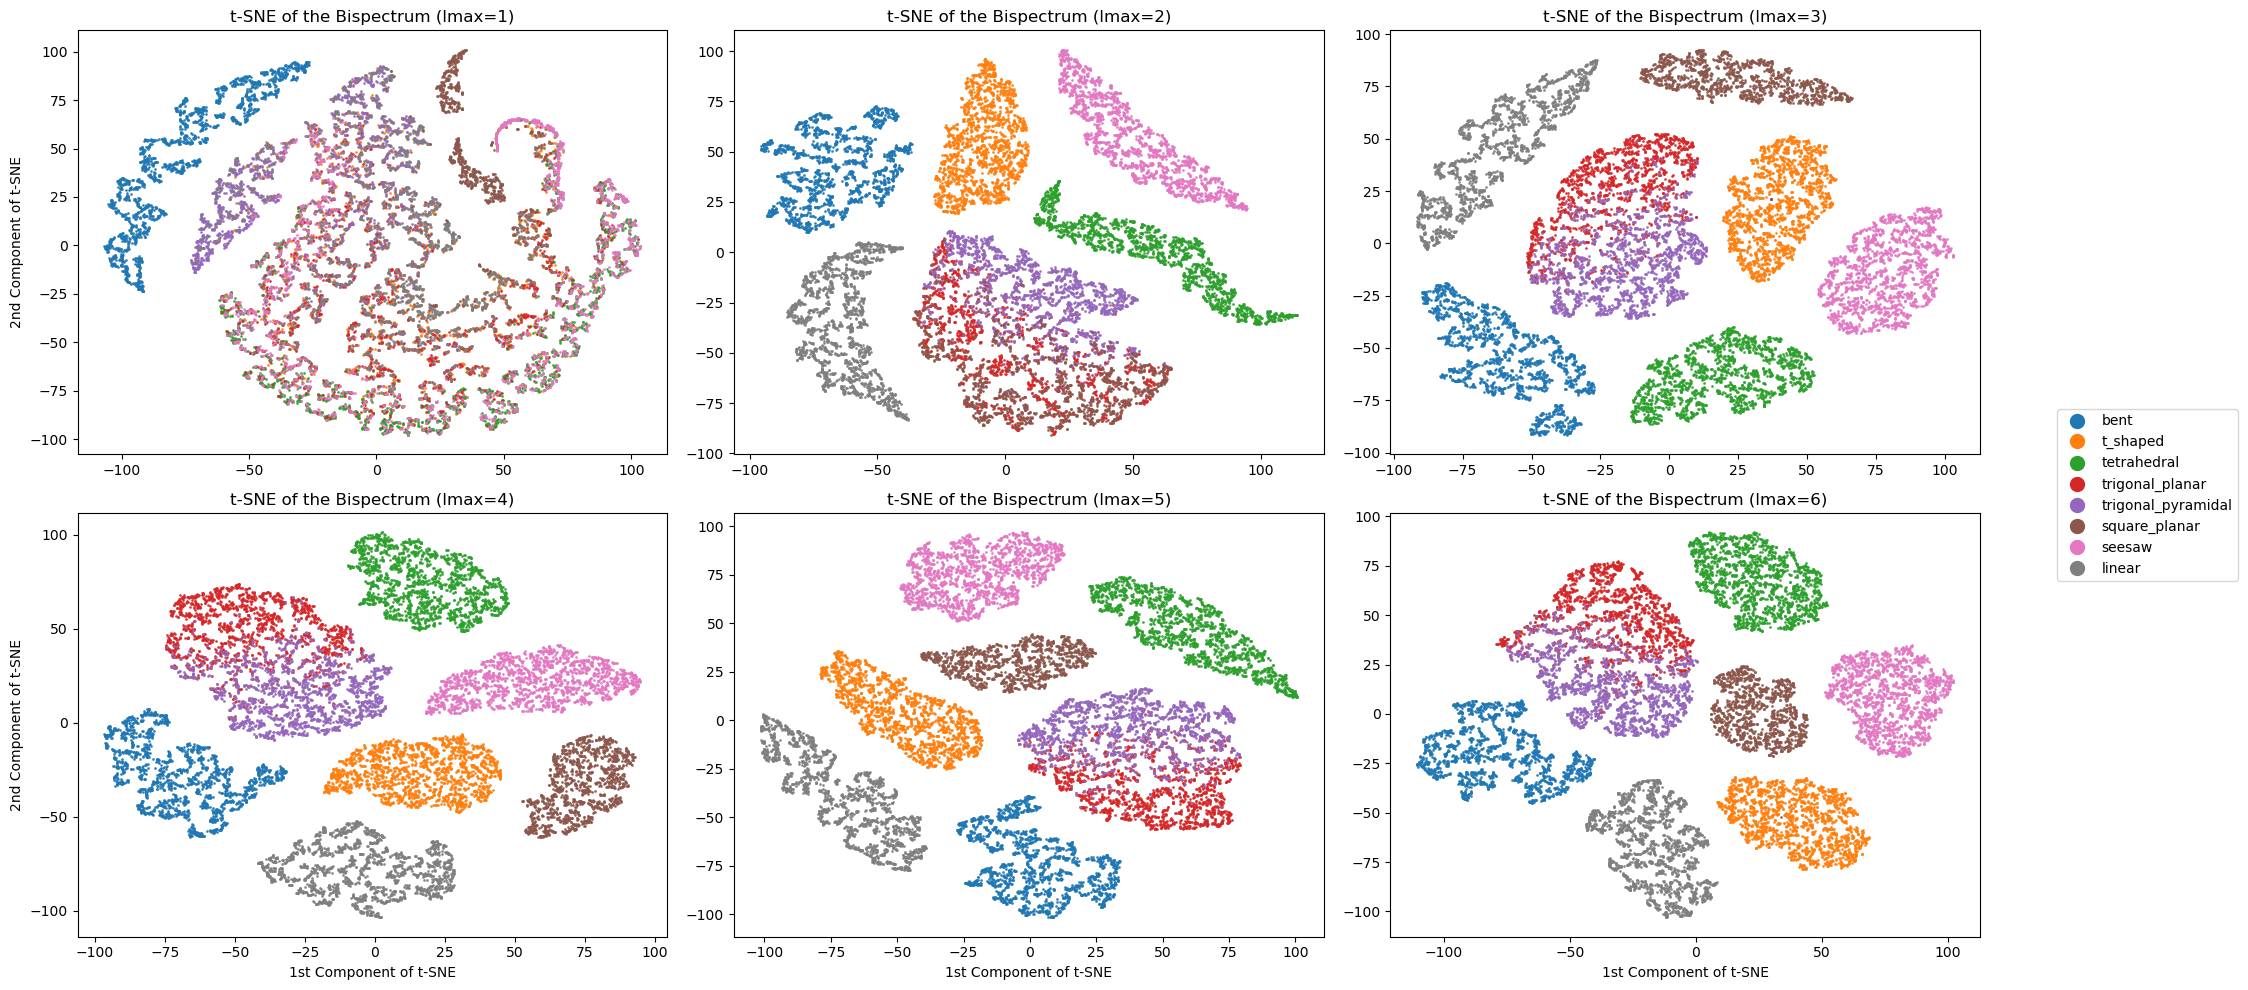

In [44]:
plot_spectra_dim_reduction(molecular_geometries_df, "bispectrum", "tsne")

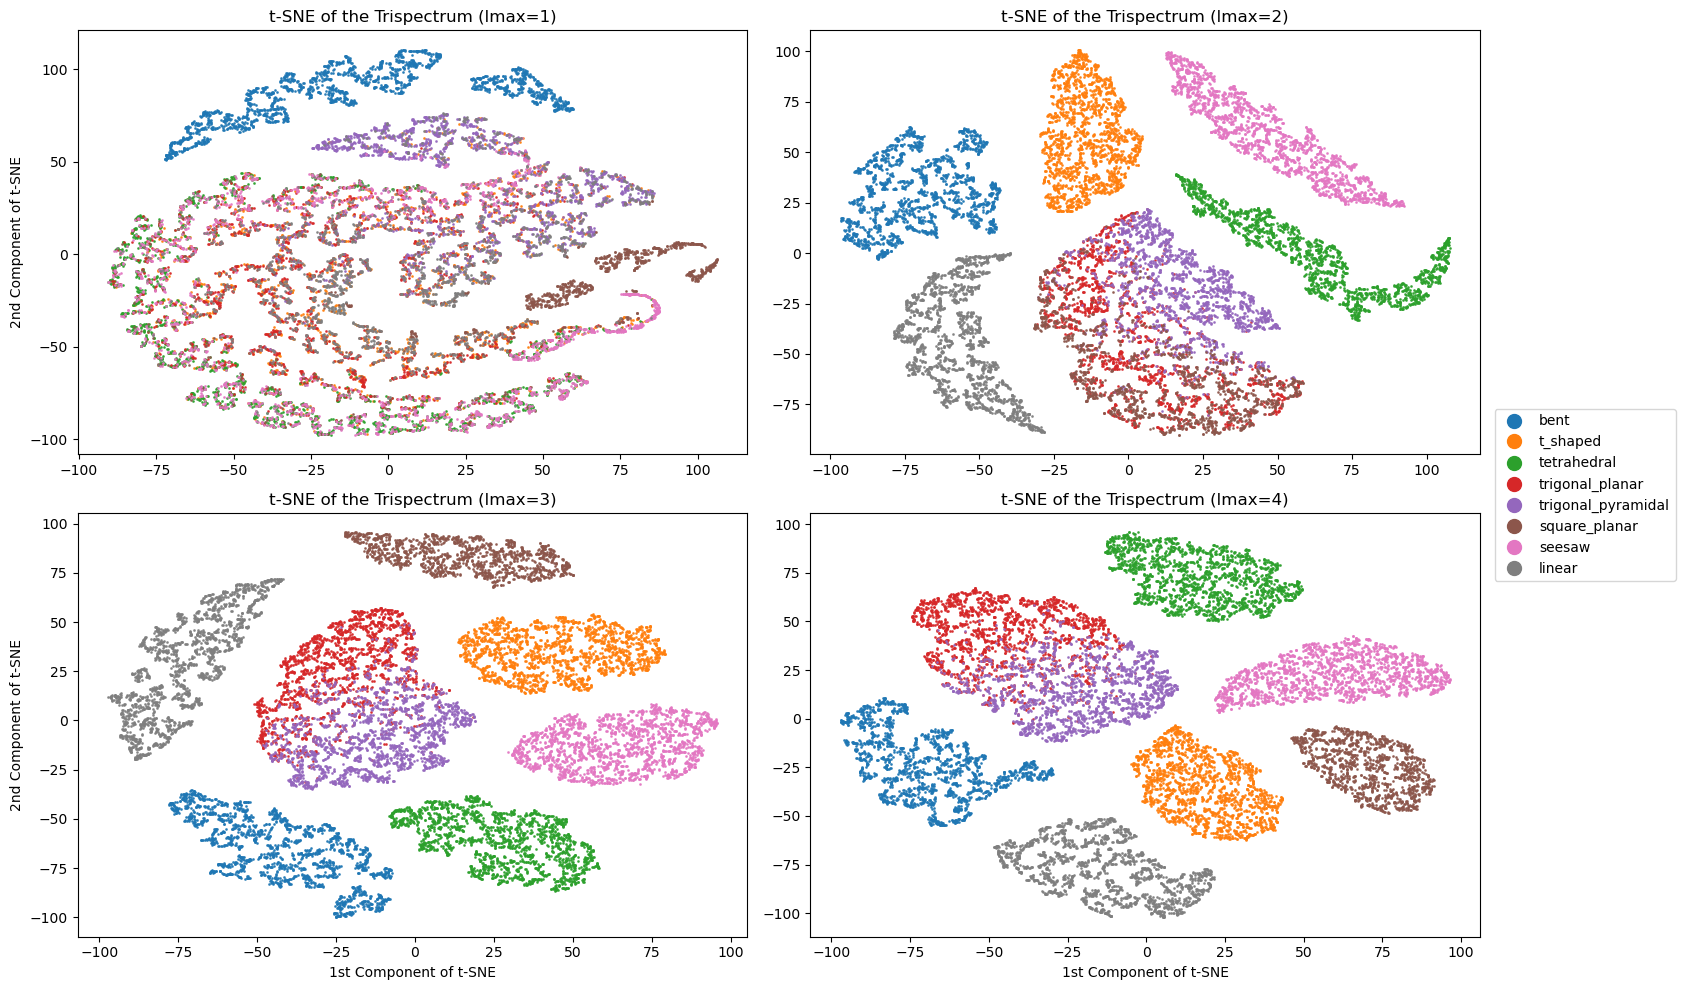

In [45]:
plot_spectra_dim_reduction(molecular_geometries_df, "trispectrum", "tsne")

In [48]:
set(molecular_geometries_df.category)

{'bent',
 'linear',
 'seesaw',
 'square_planar',
 't_shaped',
 'tetrahedral',
 'trigonal_planar',
 'trigonal_pyramidal'}

From this, we can see that $l_{max}=1,2$ are not expressive enough to distinguish between some of the geometries, which is to be expected.

Additionally, it is concerning that 4 of the 12 original geomtries do not show up - this is likely a bug with the current implementation of `compute_sp_expansion` compared to `with_peaks_at` in `e3nn-torch`.

Training a logistic regression classifier on the spectra of these geomtries gives interesting results:

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

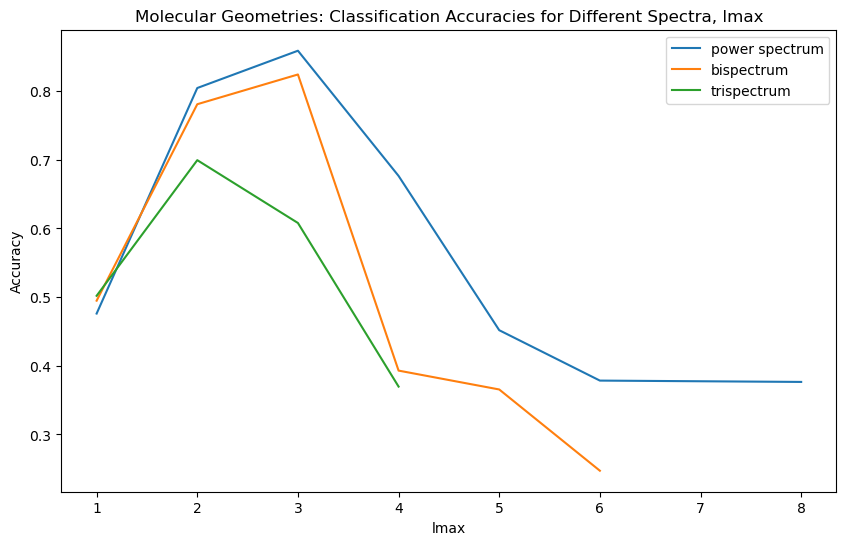

In [87]:
plot_classification_accuracies(molecular_geometries_df, title='Molecular Geometries: Classification Accuracies for Different Spectra, lmax')

These results show that beyond $l_{max} = 3$, the ability to differentiate between common geometries *when using a logistic classifier* decreases. This is unexpected, as higher order $l_{max}$ should more precisely capture the original local geometry. However, this is likely due to the drawbacks with using logistic classification on vectors with more correlated features.

## Study 3: Inverting the Power Spectrum and Bispectrum

The following demonstration shows that inverting the power spectrum and bispectrum can fail in that the inverted geometry is significantly different that the original geometry. However, similar experiments using `e3nn-torch` have not had the same issues, so this may be a problem with the current implementation.

In order to invert spectra, we start with an initial guess for the original geometry. The spectra of this guess can be computed, and the difference bewteen the guess spectra and true spectra can be taken to be the (L2) loss. Performing gradient descent on this will ideally result in obtaining the original geometry, up to rotation. We can then compute the rotation matrix to align the inverted geometry with the original geometry. 

In [60]:
lmax = 6
p_val = 1
p_arg = -1

def signal_from_params(params: optax.Params) -> e3nn.IrrepsArray:
    """Creates signal from current parameters.
    
    Args:
        params (optax.Params): Input parameters.

    Returns:
        e3nn.IrrepsArray: Output signal.
    """
    other_vec = params["other_vec"]
    return e3nn.sum(e3nn.s2_dirac(other_vec, lmax=lmax, p_val=p_val, p_arg=p_arg) * jnp.linalg.norm(other_vec, axis=-1)[:, None], axis=0)

def loss(
    params: optax.Params, true_spectrum: chex.Array, true_bispectrum: chex.Array
) -> chex.Array:
    """Computes the loss corresponding to the current parameters.
    
    Args:
        params (optax.Params): Input parameters.
        true_spectrum (chex.Array): True power spectrum.
        true_bispectrum (chex.Array): True bispectrum.

    Returns:
        chex.Array: The loss value.
    """
    # Compute signal.
    pred_sig = signal_from_params(params)

    # Compute spectrum and bispectrum.
    pred_spectrum = powerspectrum(pred_sig)
    pred_bispectrum = bispectrum(pred_sig)

    # Compute loss.
    loss_value = (
        optax.l2_loss(true_spectrum, pred_spectrum).mean()
        + optax.l2_loss(true_bispectrum, pred_bispectrum).mean()
    )
    return loss_value

def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation,
    true_spectrum: chex.Array,
    true_bispectrum: chex.Array,
    max_iter: int = 2500,
) -> optax.Params:
    """Performs fitting on the provided parameters.
    
    Args:
        params (optax.Params): Initial parameters.
        optimizer (optax.GradientTransformation): The optimizer to use.
        true_spectrum (chex.Array): True power spectrum.
        true_bispectrum (chex.Array): True bispectrum.
        max_iter (int, optional): Maximum number of iterations. Defaults to 2500.

    Returns:
        optax.Params: The fitted parameters.
    """
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, true_spectrum, true_bispectrum):
        loss_value, grads = jax.value_and_grad(loss)(
            params, true_spectrum, true_bispectrum
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for iter in range(max_iter):
        params, opt_state, loss_value = step(
            params, opt_state, true_spectrum, true_bispectrum
        )
        if iter % 100 == 0:
            print(f"step {iter}, loss: {loss_value}")

    return params

def invert_spectrum(true_spectrum, true_bispectrum):
    """Given true_spectrum and true_bispectrum, finds the parameters which would generate them.
    
    Args:
        true_spectrum (chex.Array): True power spectrum.
        true_bispectrum (chex.Array): True bispectrum.

    Returns:
        optax.Params: The parameters that would generate the given spectrum and bispectrum.
    """
    rng = jax.random.PRNGKey(0)
    init_rng, rng = jax.random.split(rng)
    init_params = {"other_vec": jax.random.normal(init_rng, (12, 3))}
    optimizer = optax.adam(learning_rate=1e-2)
    params = fit(init_params, optimizer, true_spectrum, true_bispectrum)
    return params


In [61]:
def mse_rot_closest(
    w: chex.Array, sig1: e3nn.SphericalSignal, sig2: e3nn.SphericalSignal
):
    """
    Compute the mean squared distance between each point in rotated sig1 
    to its closest point in sig2.

    Args:
    w: Quaternion array of shape (4,).
    sig1: First spherical signal to be rotated.
    sig2: Second spherical signal for comparison.

    Returns:
    Mean of the minimum squared distances.
    """
    assert w.shape == (4,)
    sig1_rot = sig1.transform_by_quaternion(w, lmax=lmax)
    r1_rot = sig1_rot.grid_vectors * sig1_rot.grid_values[..., None]
    r2 = sig2.grid_vectors * sig2.grid_values[..., None]
    r1_rot = r1_rot.reshape((-1, 3))
    r2 = r2.reshape((-1, 3))
    distances = jnp.linalg.norm(r1_rot[:, None, :] - r2[None, :, :], axis=-1) ** 2
    return jnp.min(distances, axis=-1).mean()


@jax.jit
def optimal_rotation(
    sig1: e3nn.SphericalSignal,
    sig2: e3nn.SphericalSignal,
    *,
    steps: int = 256,
    lr: float = 1e-2,
    rng: chex.PRNGKey,
) -> Tuple[chex.Array, chex.Numeric]:
    """
    Returns the optimal rotation matrix and corresponding alignment error 
    to rotate sig1 onto sig2.

    Args:
    sig1: First spherical signal.
    sig2: Second spherical signal.
    steps: Number of steps for optimization. Default is 256.
    lr: Learning rate for optimization. Default is 1e-2.
    rng: Random number generator key.

    Returns:
    Tuple of optimal rotation matrix and corresponding alignment error.
    """

    def optimize(w):
        optimizer = optax.adam(lr)
        opt_state = optimizer.init(w)

        def update(_, state):
            w, opt_state = state
            loss, grad = jax.value_and_grad(mse_rot_closest)(w, sig1, sig2)
            u, s = optimizer.update(grad, opt_state, w)
            w = optax.apply_updates(w, u)
            return w, opt_state

        w, s = jax.lax.fori_loop(0, steps, update, (w, opt_state))
        return w

    ws = jax.random.normal(rng, (10, 4))
    optimal_ws = jax.vmap(optimize)(ws)
    ls = jax.vmap(mse_rot_closest, (0, None, None))(optimal_ws, sig1, sig2)
    optimal_l = jnp.nanmin(ls)
    optimal_w = optimal_ws[jnp.nanargmin(ls)]
    optimal_R = e3nn.quaternion_to_matrix(optimal_w)
    return optimal_R, optimal_l


def compute_alignment_loss(params, true_sig, steps=256, lr=1e-2, rng=None):
    """
    Compute the alignment loss for given parameters and true signal.

    Args:
    params: Parameters for the signal.
    true_sig: True spherical signal.
    steps: Number of steps for optimization. Default is 256.
    lr: Learning rate for optimization. Default is 1e-2.
    rng: Random number generator key.

    Returns:
    Alignment loss if not provided.

    """
    # Compute optimal rotation.
    rng = jax.random.PRNGKey(0)
    pred_sig = signal_from_params(params)
    w_rng, rng = jax.random.split(rng)
    R, loss = optimal_rotation(
        e3nn.to_s2grid(pred_sig, 30, 29, quadrature="soft"),
        e3nn.to_s2grid(true_sig, 30, 29, quadrature="soft"),
        rng=w_rng,
    )
    pred_sig = pred_sig.transform_by_matrix(R)
    print(f"Alignment loss = {loss}")
    return pred_sig, loss





In [63]:
row = dimensional_geometries_df.iloc[1]
true_geometry = row.geometry
true_sig = compute_sh_expansion(true_geometry, lmax=6)
true_spectrum = row.powerspectrum6
true_bispectrum = row.bispectrum6
params = invert_spectrum(true_spectrum, true_bispectrum)

step 0, loss: 0.8831436038017273
step 100, loss: 0.0423906072974205
step 200, loss: 0.012274673208594322
step 300, loss: 0.006358348298817873
step 400, loss: 0.0038843124639242887
step 500, loss: 0.002564291935414076
step 600, loss: 0.0017800453351810575
step 700, loss: 0.0012903063325211406
step 800, loss: 0.0009625392849557102
step 900, loss: 0.0007332084351219237
step 1000, loss: 0.0005698168533854187
step 1100, loss: 0.00044944483670406044
step 1200, loss: 0.00035889638820663095
step 1300, loss: 0.0002897203667089343
step 1400, loss: 0.00023608312767464668
step 1500, loss: 0.00019406845967750996
step 1600, loss: 0.00016079981287475675
step 1700, loss: 0.00013416765432339162
step 1800, loss: 0.00011263391934335232
step 1900, loss: 9.506631613476202e-05
step 2000, loss: 8.067807357292622e-05
step 2100, loss: 6.879001739434898e-05
step 2200, loss: 5.8905065088765696e-05
step 2300, loss: 5.0637951062526554e-05
step 2400, loss: 4.3687181459972635e-05


In [64]:
pred_sig, loss = compute_alignment_loss(params, true_sig)

Alignment loss = 0.08639886230230331


In [67]:
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        bgcolor='rgba(255,255,255,0)',
        aspectmode='data',
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)

go.Figure(data=[go.Surface(e3nn.to_s2grid(true_sig, 100, 99, quadrature="soft").plotly_surface(scale_radius_by_amplitude=True))], layout=layout)

In [68]:
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(0,0,0,0)'),
        bgcolor='rgba(255,255,255,0)',
        aspectmode='data',
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=0, b=0)
)

go.Figure(data=[go.Surface(e3nn.to_s2grid(pred_sig, 100, 99, quadrature="soft").plotly_surface(scale_radius_by_amplitude=True))], layout=layout)

In [84]:
def colorplot(arr: jnp.ndarray):
    """Helper to plot a 1D array as a color plot."""
    plt.figure(figsize=(15, 1))
    plt.axis("off")
    vmax = jnp.maximum(jnp.abs(jnp.min(arr)), jnp.max(arr))
    return plt.imshow(arr[None, :], cmap="RdBu", vmin=-vmax, vmax=vmax)

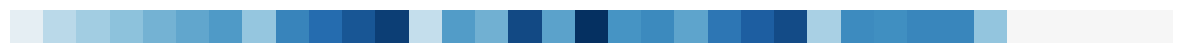

In [86]:
colorplot(true_bispectrum)

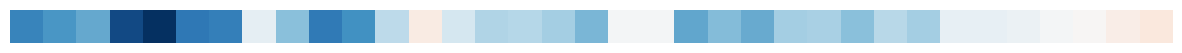

In [85]:
colorplot(bispectrum(pred_sig))

The geometry found after inverting has two distinct peaks, while the original geometry only has one distinct peak in this example. Their bispectra are also distinct. Again, this is unexpected and likely a bug, as different results are seen when using `e3nn-torch`

## Conclusion

###  Summary of previous sections and take-aways.

Spectra seem like a promising way to characterize the geometry of local environments as they are invariant to translation, rotation, and permutation of identical atoms. While they are unable to distinguish between 2D-constrained and 3D points, spectra are effective at distinguishing between different common molecular geometries at sufficiently high $l_{max}$. 

Additionally, it is possible to invert a geometry given its power spectrum and bispectrum using gradient descent with an initial guess of points. However, the current implementation is not perfect (and something is likely incorrect, as the same inversion process in `e3nn-torch` is much more robust), and there is more work to be done in considering how robust the invertibility is if only different combinations of spectra order and $l_{max}$ are used for inversion.